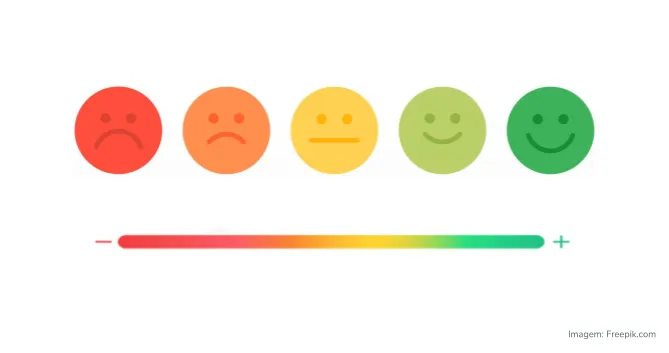

# Combinando modelos de Machine Learning com Lógica Fuzzy — Parte 2

*Esta é a segunda e última parte do conteúdo sobre combinação de modelos de Machine Learning com Lógica Fuzzy. Na primeira parte, falei sobre a nossa motivação em utilizar lógica fuzzy, seus conceitos e como construir um sistema de controle fuzzy. Ela é essencial para o entendimento desta segunda parte; portanto, não deixe de conferi-la [aqui](https://github.com/renangarciarosa/Logica-Fuzzy-Machine-Learning/blob/main/ML_com_Logica_Fuzzy_Parte_01.ipynb).*

Para fazer a combinação dos modelos por meio de lógica fuzzy com Python, nós utilizamos o pacote [scikit-fuzzy](https://github.com/scikit-fuzzy/scikit-fuzzy). Na documentação, temos um exemplo de sua aplicação para um [problema de se dar uma gorjeta](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html) (em que, dada a qualidade do serviço e do prato pedido, deseja-se saber quanto de gorjeta deve ser dada). Como esse exemplo já está bem explicado, vamos imaginar um outro caso aqui para ilustrar e vermos a aplicação da lógica fuzzy em outro cenário 🙂

Imagine então que temos dois modelos: um modelo de regressão que prediz o valor de um imóvel ([como dessa competição famosa do Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)) e um modelo de classificação que prediz a chance de um imóvel ser vendido. Poderíamos então combinar esses dois modelos para dizer o quão bom um imóvel é:

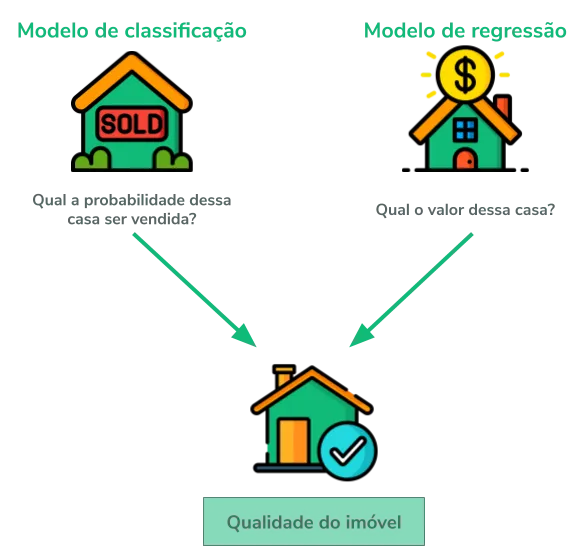

Agora que já conhecemos os conceitos de um sistema de controle fuzzy, vamos aplicar o passo a passo no caso acima para criarmos um sistema que retorne a qualidade de um imóvel. Primeiramente, vamos definir as entradas e a saída do nosso sistema:

#### Entradas

***Valor***

* Universo (intervalo de valores crisp): o quão alto é o preço do imóvel, considerando uma escala entre 100.000 a 1.000.000 reais?
* Conjunto fuzzy (intervalo de valores fuzzy): baixo, médio e alto

***Venda***

* Universo: considerando um valor entre 0 e 1, qual a chance do imóvel ser vendido?
* Conjunto fuzzy: baixa, média e alta

#### Saída

***Qualidade***

* Universo: qual a qualidade do imóvel, numa escala entre 0 e 100?
* Conjunto fuzzy: ruim, mediana e boa


Vamos agora passar todas essas definições para o Python utilizando o scikit-fuzzy:

In [ ]:
!pip install scikit-fuzzy

In [3]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# DEFINIÇÕES DOS UNIVERSOS

# antecedentes, que serão as predições indicando a probabilidade do imóvel ser vendido e o seu valor
venda = ctrl.Antecedent(np.arange(0, 1.01, .01), 'venda')
preco = ctrl.Antecedent(np.arange(100000, 1001000, 1000), 'preco')

# consequente, que será a qualidade do imóvel
qualidade = ctrl.Consequent(np.arange(0, 100.1, .1), 'qualidade')

Acima, utilizamos o módulo control que tem as classes Antecedent e Consequent para definir as variáveis de entrada e saída, respectivamente. Essas classes recebem como parâmetros o universo e a label com o nome da variável.

O universo deve ser um array com os possíveis valores (não só os valores mínimo e máximo). Por isso, utilizamos a função arange do numpy para gerar esse array. Nessa função fornecemos 3 parâmetros: o valor inicial, o valor final e o passo, mas é importante dizer que o valor final não estará incluído no array (por isso no código os valores finais para cada variável estão maiores do que definimos no universo).

Após essa definição inicial, vamos definir as funções de pertinência para os antecedentes e o consequente:

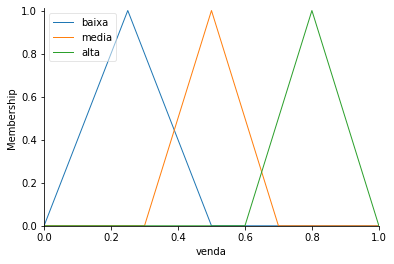

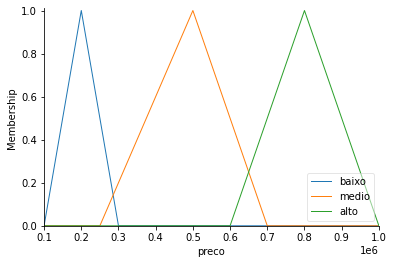

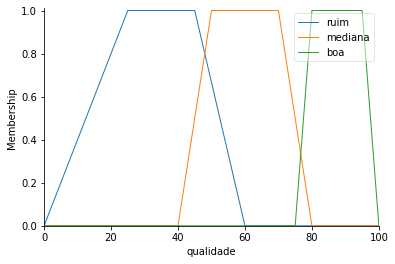

In [4]:
# DEFINIÇÕES DAS FUNÇÕES DE PERTINÊNCIA
# venda
venda['baixa'] = fuzz.trimf(venda.universe, [0, 0.25, 0.5])
venda['media'] = fuzz.trimf(venda.universe, [0.3,0.5,0.7])
venda['alta'] = fuzz.trimf(venda.universe, [0.6,0.8,1])

# preço
preco['baixo'] = fuzz.trimf(preco.universe, [100000, 200000,300000])
preco['medio'] = fuzz.trimf(preco.universe, [250000, 500000, 700000])
preco['alto'] = fuzz.trimf(preco.universe, [600000, 800000, 1000000])

# qualidade
qualidade['ruim'] = fuzz.trapmf(qualidade.universe, [0, 25, 45,60])
qualidade['mediana'] = fuzz.trapmf(qualidade.universe, [40, 50, 70,80])
qualidade['boa'] = fuzz.trapmf(qualidade.universe, [75, 80,95,100])

# VISUALIZAÇÃO DAS FUNÇÕES DE PERTINÊNCIA
# venda
venda.view()

# preco
preco.view()

# qualidade
qualidade.view()

No código acima, arbitrariamente escolhemos as funções de pertinência das variáveis. Para a venda e o preço, optamos pela função triangular (definida com a função trimf), enquanto que a qualidade foi definida com a função trapezoidal (com a função trapmf). Ambas receberam dois argumentos: o universo das variáveis que definimos no código anterior e um array para definir o formato dos triângulos e trapézios (para a função triangular, o array deve ter 3 elementos, enquanto que para a trapezoidal precisa ter 4). Os valores desses arrays que definem os formatos também foram escolhidos empiricamente.
No código acima também utilizamos a função view, com a qual conseguimos visualizar as funções de pertinência definidas para cada antecedente e consequente:

No código acima também utilizamos a função view, com a qual conseguimos visualizar as funções de pertinência definidas para cada antecedente e consequente:

Em seguida, vamos criar as regras para esse sistema:

In [5]:
# regra 1 - se probabilidade venda é baixa, então qualidade é ruim
regra1 = ctrl.Rule(venda['baixa'], qualidade['ruim'])

# regra 2 - se probabilidade venda é médio ou o preço é médio, então qualidade é mediana
regra2 = ctrl.Rule(venda['media'] | preco['medio'], qualidade['mediana'])

# regra 3 - se probabilidade venda é alta e o preço é alto, então qualidade é boa
regra3 = ctrl.Rule(venda['alta'] & preco['alto'], qualidade['boa'])

# regra 4 - se probabilidade venda é médio ou o preço é baixo, então qualidade é mediana
regra4 = ctrl.Rule(venda['media'] | preco['baixo'], qualidade['mediana'])

# regra 5 - se probabilidade venda é baixa e o preço é alto, então qualidade é mediana
regra5 = ctrl.Rule(venda['baixa'] & preco['alto'], qualidade['mediana'])

imovel_ctrl = ctrl.ControlSystem([regra1, regra2, regra3, regra4, regra5])
engine = ctrl.ControlSystemSimulation(imovel_ctrl)

Podemos observar que foram definidas 5 regras para esse sistema utilizando a classe Rule, para o qual foram passados dois parâmetros para ela: o antecedente (em que para algumas regras foram utilizados os operadores E ou OU para relacionar duas variáveis de entrada) e o consequente. Novamente, essas regras foram escolhidas empiricamente.

Após a definição das regras, temos as linhas 16 e 17 do código acima, em que passamos as regras para o sistema de controle definido pela classe ControlSystem e, para simular esse sistema, criamos o ControlSystemSimulation. Agora que temos o sistema pronto, podemos fornecer dois valores de entrada como exemplo para verificar qual será a saída do sistema:

60.0


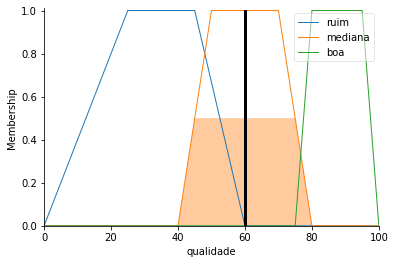

In [6]:
# passa as predições dos modelos para suas respectivas variáveis de entrada
engine.input['venda'] = 0.8
engine.input['preco'] = 150000

# calcula a saída do sistema de controle fuzzy
engine.compute()

# retorna o valor crisp e o gráfico mostrando-o
print(engine.output['qualidade'])
qualidade.view(sim=engine)

No exemplo acima, fornecemos como entrada uma predição do modelo de classificação que retornou que esse imóvel tem 80% de probabilidade de ser vendido, enquanto que a predição do modelo de regressão foi de que o valor do imóvel é de R$ 150.000,00.

Utilizamos então a função compute para calcular qual a saída do sistema fuzzy. Importante notar que estamos utilizando os parâmetros default da biblioteca para fazer as etapas de inferência fuzzy e a defuzzificação. Você pode checar a documentação caso queira utilizar outros métodos para essas etapas.

Como retorno para o exemplo acima, o print informa que a saída é igual a 60 e também temos o seguinte gráfico retornado:

Agora vamos supor que os modelos fizeram predições para um outro imóvel e retornaram uma predição de venda igual a 0.78 e um valor de imóvel de R$ 680.000,00. Para esse caso, o sistema retorna uma saída de 79.37 e o seguinte gráfico abaixo:

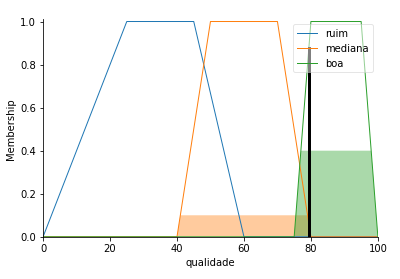

Ótimo, agora temos saídas para dois imóveis! O que podemos fazer com elas? Com as saídas do sistema de controle fuzzy, sabemos que o segundo imóvel tem uma qualidade maior do que o primeiro. Poderíamos dar mais destaque para esse segundo imóvel, visto que sabemos que ele é melhor e deve vender mais rápido ou poderíamos dar um desconto para o primeiro imóvel, visto que sua qualidade é inferior. Enfim, são muitas as possibilidades de utilização das saídas do sistema de controle utilizando lógica fuzzy!

# Vantagens e desvantagens de se utilizar lógica fuzzy
Dentre as vantagens que podemos citar sobre a utilização de lógica fuzzy para combinar modelos de Machine Learning é de que definições das variáveis e das regras podem ser facilmente entendidas e podem (e deveriam) ser definidas em conjunto com pessoas de outras áreas.

Uma outra grande vantagem de utilizar a lógica fuzzy como mostramos no artigo é que conseguimos escolher a forma como a saída do sistema de controle será, de modo que ela faça sentido para o negócio e que seja facilmente entendida pelas pessoas. Pegando o exemplo de se definir a qualidade do imóvel novamente: se utilizássemos a abordagem que citei na primeira parte do conteúdo e fizéssemos simplesmente uma multiplicação das predições dos dois modelos de Machine Learning que retornam o preço e a vendabilidade dos imóveis, o resultado dessa multiplicação por si só não quer dizer nada (por exemplo, para um imóvel que tem 50% de probabilidade de ser vendido e cuja estimativa de preço é de R$ 100.000,00, uma saída de 50.000 não quer dizer que o imóvel será vendido por esse valor). Já com a lógica fuzzy, podemos criar um score (com o intervalo que acharmos que faça sentido) assim como fizemos acima, em que o imóvel pode ter valores entre 0 e 100 e que quanto maior, maior é a qualidade do imóvel. Com isso, sua saída fica muito mais intuitiva.

Por fim, uma outra vantagem é de que, com as regras da lógica fuzzy, não teríamos mais o dilema de escolher, pensando no exemplo do imóvel, se seria melhor focar em um imóvel mais barato, mas com mais chances de ser vendido, ou em um imóvel mais caro, mas com menores chances de ser vendido. Com o sistema de controle, podemos definir as regras que achamos que fazem sentido e as testamos para verificar se as premissas assumidas de fato estão coerentes.

Já uma das grandes desvantagens de utilizar lógica fuzzy é que muitas coisas precisam ser definidas: as variáveis de entrada e saída; seus universos e termos que serão assumidos no conjunto fuzzy; funções de pertinência e regras. Essas duas últimas em especial são bem complicadas de serem definidas e, como foi possível ver no último exemplo, geralmente são escolhidas empiricamente (ou necessitam de uma pessoa super especialista que nos ajude com todas essas definições).

Além disso, como essas definições comumente são feitas dessa maneira empírica, são necessárias muitas validações e testes para verificar se as saídas do sistema de controle fuzzy realmente estão fazendo sentido. Para isso, poderíamos aplicar um teste A/B (ou quem sabe usar o Multi-Armed Bandit que o Bruno explicou muito bem neste artigo aqui) para testar se as definições escolhidas para o sistema de controle fuzzy estão resolvendo nosso problema ou se é necessário mudá-las e tentar de novo.

# Conclusão
A Lógica Fuzzy, apesar de necessitar de várias definições, é de fácil entendimento e pode trazer diversas vantagens para o negócio. No caso do projeto que mencionei na primeira parte do artigo, quando combinamos os dois modelos por meio da multiplicação, só tivemos o melhor resultado em uma das métricas que analisamos, enquanto que utilizar só o modelo de classificação era melhor nas demais métricas. Já ao utilizar lógica fuzzy para fazer essa combinação, obtivemos os melhores resultados para todas as métricas analisadas, o que nos mostrou que sua utilização poderia trazer um potencial ganho para a Creditas.

Espero que esse artigo tenha ajudado no entendimento da lógica fuzzy e de como ela pode ser utilizada caso se deseje fazer a combinação de predições de modelos de Machine Learning 😃